In [1]:
import pandas as pd
import numpy as np
import csv as csv
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Data cleanup
# TRAIN DATA
train_df = pd.read_csv('train.csv', header=0)        # Load the train file into a dataframe

# I need to convert all strings to integer classifiers.
# I need to fill in the missing values of the data and make it complete.

# female = 0, Male = 1
train_df['Gender'] = train_df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

# Embarked from 'C', 'Q', 'S'
# Note this is not ideal: in translating categories to numbers, Port "2" is not 2 times greater than Port "1", etc.

# All missing Embarked -> just make them embark from most common place
if len(train_df.Embarked[ train_df.Embarked.isnull() ]) > 0:
    train_df['Embarked'].fillna(train_df.Embarked.dropna().value_counts().idxmax(), inplace=True)

Ports = list(enumerate(np.unique(train_df['Embarked'])))    # determine all values of Embarked,
Ports_dict = { name : i for i, name in Ports }              # set up a dictionary in the form  Ports : index
train_df.Embarked = train_df.Embarked.map( lambda x: Ports_dict[x]).astype(int)     # Convert all Embark strings to int

# All the ages with no data -> make the median of all Ages
median_age = train_df['Age'].dropna().median()
if len(train_df.Age[ train_df.Age.isnull() ]) > 0:
    train_df.loc[ (train_df.Age.isnull()), 'Age'] = median_age

# Remove the Name column, Cabin, Ticket, and Sex (since I copied and filled it to Gender)
train_df = train_df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'PassengerId'], axis=1)

In [3]:
# TEST DATA
test_df = pd.read_csv('test.csv', header=0)        # Load the test file into a dataframe

# I need to do the same with the test data now, so that the columns are the same as the training data
# I need to convert all strings to integer classifiers:
# female = 0, Male = 1
test_df['Gender'] = test_df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

# Embarked from 'C', 'Q', 'S'
# All missing Embarked -> just make them embark from most common place
if len(test_df.Embarked[ test_df.Embarked.isnull() ]) > 0:
    test_df['Embarked'].fillna(test_df.Embarked.dropna().value_counts().idxmax(), inplace=True)
# Again convert all Embarked strings to int
test_df.Embarked = test_df.Embarked.map( lambda x: Ports_dict[x]).astype(int)


# All the ages with no data -> make the median of all Ages
median_age = test_df['Age'].dropna().median()
if len(test_df.Age[ test_df.Age.isnull() ]) > 0:
    test_df.loc[ (test_df.Age.isnull()), 'Age'] = median_age

# All the missing Fares -> assume median of their respective class
if len(test_df.Fare[ test_df.Fare.isnull() ]) > 0:
    median_fare = np.zeros(3)
    for f in range(0,3):                                              # loop 0 to 2
        median_fare[f] = test_df[ test_df.Pclass == f+1 ]['Fare'].dropna().median()
    for f in range(0,3):                                              # loop 0 to 2
        test_df.loc[ (test_df.Fare.isnull()) & (test_df.Pclass == f+1 ), 'Fare'] = median_fare[f]

# Collect the test data's PassengerIds before dropping it
ids = test_df['PassengerId'].values
# Remove the Name column, Cabin, Ticket, and Sex (since I copied and filled it to Gender)
test_df = test_df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'PassengerId'], axis=1)

In [66]:
# The data is now ready to go. So lets fit to the train, then predict to the test!
# Convert back to a numpy array
train_data = train_df.values
test_data = test_df.values
names = np.array(train_df.columns.values)
names

array(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'Gender'], dtype=object)

In [53]:
# the direct rf with 100 trees
forest = RandomForestClassifier(n_estimators=184, max_depth=8, max_features=None, random_state=314159)
score = cross_validation.cross_val_score(forest, train_data[0::,1::], train_data[0::,0], cv=10)
print "the score is {}".format(score)
forest.fit(train_data[0::,1::], train_data[0::,0])
print "the feature importance is {}".format(forest.feature_importances_)

In [43]:
# oob
RANDOM_STATE = 314159
# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for paralellised ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

the min val is 0.157126823793 as 184


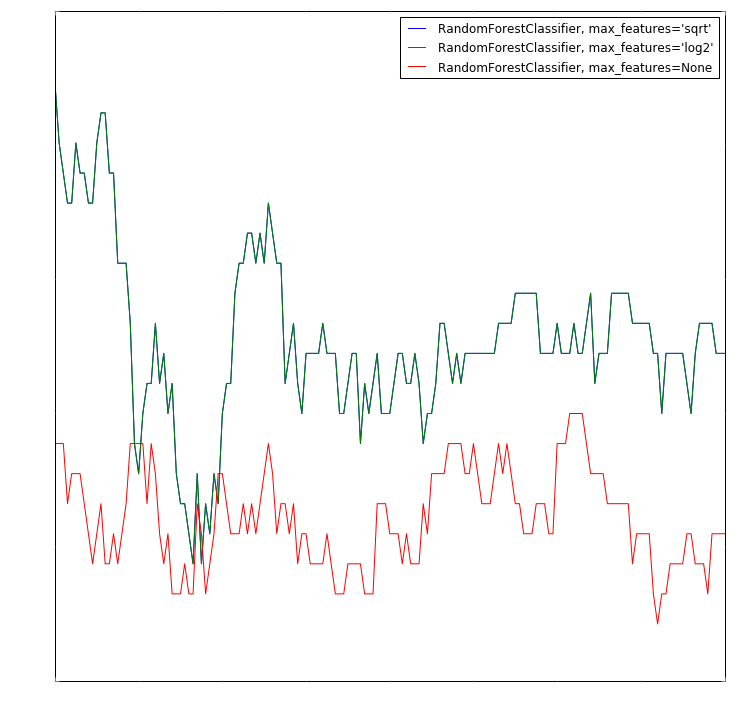

In [44]:
# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 40
max_estimators = 200

for label, clf in ensemble_clfs:
    clf.set_params(max_depth=8)
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(train_data[0::,1::], train_data[0::,0])

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    if label == "RandomForestClassifier, max_features=None":
        ys_np = np.array(ys)
        xs_np = np.array(xs)
        val = np.min(ys_np)
        n = xs_np[ys.index(val)]
    plt.plot(xs, ys, label=label)

print "the min val is {} as {}".format(val, n)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
plt.show()

the min val is 0.157126823793 as 8


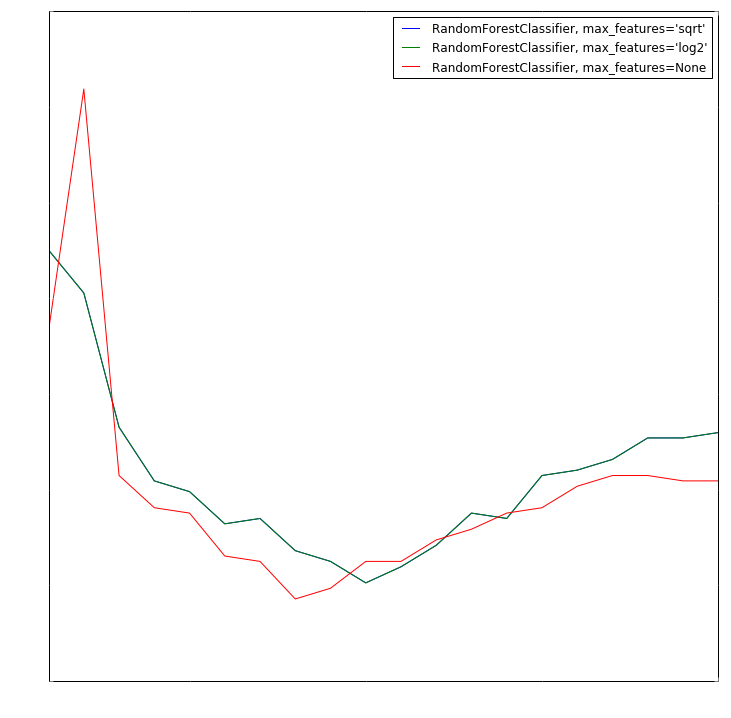

In [45]:
# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_max_depth = 1
max_max_depth = 20

for label, clf in ensemble_clfs:
    clf.set_params(warm_start=False)
    clf.set_params(n_estimators=184)
    for i in range(min_max_depth, max_max_depth + 1):
        clf.set_params(max_depth=i)
        clf.fit(train_data[0::,1::], train_data[0::,0])

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    if label == "RandomForestClassifier, max_features=None":
        ys_np = np.array(ys)
        xs_np = np.array(xs)
        val = np.min(ys_np)
        n = xs_np[ys.index(val)]
    plt.plot(xs, ys, label=label)
print "the min val is {} as {}".format(val, n)
plt.xlim(min_max_depth, max_max_depth)
plt.xlabel("n_max_depth")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
plt.show()